In [20]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM,TimeDistributed,Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tenserflow.keras.models import regularizers
import matplotlib.pyplot as plt

In [21]:
BATCH_START = 0
TIME_STEPS = 15
BATCH_SIZE = 72
INPUT_SIZE = 8
OUTPUT_SIZE = 4
PRED_SIZE = 15 
CELL_SIZE = 128
LR = 0.0001
EPOSE = 50

# 输入输出文件名称
Input_file = './data/jobs.csv'
Out_flie = './data/output.csv'

In [22]:
class MyJANETLSTM(object):
    def __init__(self,n_steps, input_size, output_size, cell_size, batch_size):
        self.n_steps = n_steps
        self.input_size = input_size
        self.output_size = output_size
        self.cell_size = cell_size # LSTM神经单元数      
        self.batch_size = batch_size # 输入batch_size大小
    def model(self):
        
        self.model = Sequential() 
        
        #LSTM的输入为 [batch_size, timesteps, features],这里的timesteps为步数，features为维度
        # return_sequences = True: output at all steps. False: output as last step.
        # stateful=True: the final state of batch1 is feed into the initial state of batch2  
        # 不固定batch_size，预测时可以以1条记录进行分析
        self.model.add(LSTM(units = self.cell_size,  activation='relu', return_sequences = True , 
                            input_shape = (self.n_steps, self.input_size))
        )
        self.model.add(Dropout(0.2))        
        self.model.add(LSTM(units = self.cell_size, activation='relu', return_sequences = True))
        self.model.add(Dropout(0.2))        
        self.model.add(LSTM(units = self.cell_size, activation='relu', return_sequences = True))
        self.model.add(Dropout(0.2))

        #全连接，输出， add output layer
        self.model.add(TimeDistributed(Dense(self.output_size, recurrent_regularizer=regularizers.l2(l=0.001))))
        self.model.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
        self.model.summary()
    def train(self,x_train,y_train, epochs):
        history = self.model.fit(x_train, y_train, epochs = epochs, batch_size = self.batch_size).history
        self.model.save("lstm-model2.h5")
        
        return history

In [23]:
def get_train_data():
    df = pd.read_csv(Input_file)
    return df

In [24]:
def get_test_data():
    df = pd.read_csv(Input_file)
    df = df.iloc[-TIME_STEPS:]
    return df

In [25]:
def get_pred_data(y,z,sc):
    yy = np.concatenate((y, z),axis=1)
    y=sc.inverse_transform(yy)
    return y

In [26]:
def set_datas(df, train=True, sc=None):
    col_name = df.columns.tolist()
    if train:
        sc = MinMaxScaler(feature_range= (0,1))
        training_set = sc.fit_transform(df)
    else:
        # 测试集，也需要使用原Scaler归一化
        if sc==None:
            sc = MinMaxScaler(feature_range= (0,1))
            training_set = sc.fit_transform(df)            
        else:
            training_set = sc.transform(df)
    # 按时序长度构造数据集
    def get_batch(train_x,train_y):
        data_len = len(train_x) - TIME_STEPS
        seq = []
        res = []
        for i in range(data_len):
            seq.append(train_x[i:i + TIME_STEPS])
            res.append(train_y[i:i + TIME_STEPS]) #取后5组数据
            #res.append(train_y[i:i + TIME_STEPS]) 
         
        seq ,res = np.array(seq),np.array(res)
    
        return  seq, res
    #返回训练集
    if train:
        seq, res = get_batch(training_set[:-PRED_SIZE], training_set[PRED_SIZE:][:,0:OUTPUT_SIZE]) #0:9
    #返回测试集，一条记录
    else:
        seq, res = training_set, training_set[:,0:OUTPUT_SIZE]
        seq, res = seq[np.newaxis,:,:], res[np.newaxis,:,:]
  
    return seq, res, training_set[:,OUTPUT_SIZE:],sc,col_name,df
    

In [27]:
def train():
    df = get_train_data()
    train_x,train_y,z,sc,col_name,df = set_datas(df,True)
    # 训练集需要是batch_size的倍数
    k = len(train_x)%BATCH_SIZE
    train_x,train_y = train_x[k:], train_y[k:]

    model = MyJANETLSTM(TIME_STEPS, INPUT_SIZE, OUTPUT_SIZE, CELL_SIZE, BATCH_SIZE)
    model.model()
    history = model.train(train_x,train_y,EPOSE)
    
    plt.plot(history['loss'], linewidth=2, label='Train')
    plt.legend(loc='upper right')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()    

In [28]:
def test():
    df = get_test_data()
    seq,res,z,sc,col_name,df = set_datas(df,False) 
    seq = seq.reshape(-1,TIME_STEPS,INPUT_SIZE)
    trade_train = ['duration','cpu','memory','instances_num']
    trade_init = []
    for col in trade_train:
        trade_init.append(df[col].values)

    model = load_model('lstm-model2.h5')
    pred = model.predict(seq)
    #p1 = pred[0]

    y=get_pred_data(pred[0].reshape(TIME_STEPS,OUTPUT_SIZE),z,sc) 
    #y=get_pred_data(p1,z,sc) 

    df= pd.DataFrame(y,columns=col_name)   
    df.to_csv(Out_flie) 
    trade_pred = []
    i = 0
    for col in trade_train:
        trade_pred.append(np.concatenate((trade_init[i][:PRED_SIZE],df[col].values),axis=0))
        i =i +1
    #合并预测移动移位PRED_SIZE
    
    plt.rcParams['font.sans-serif']=['SimHei'] #显示中文标签
    plt.rcParams['axes.unicode_minus']=False    
    lables = ['duration','cpu','memory','instances_num']
    for i in range(4):
        plt.subplot(2,2,(i+1))
        plt.grid()
        plt.plot(trade_pred[i], label=lables[i])
#         plt.plot(trade_init[i])
        plt.legend()
            
    plt.show()
#     return trade_pred


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 128)           70144     
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 15, 128)           131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 4)             516       
Total para

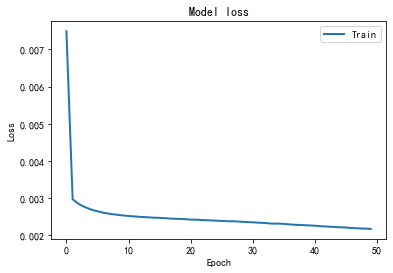

In [29]:
train()

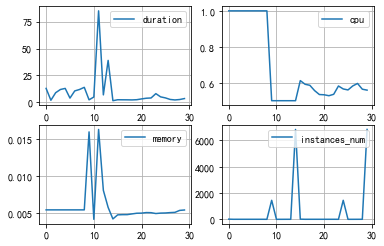

In [30]:
test()